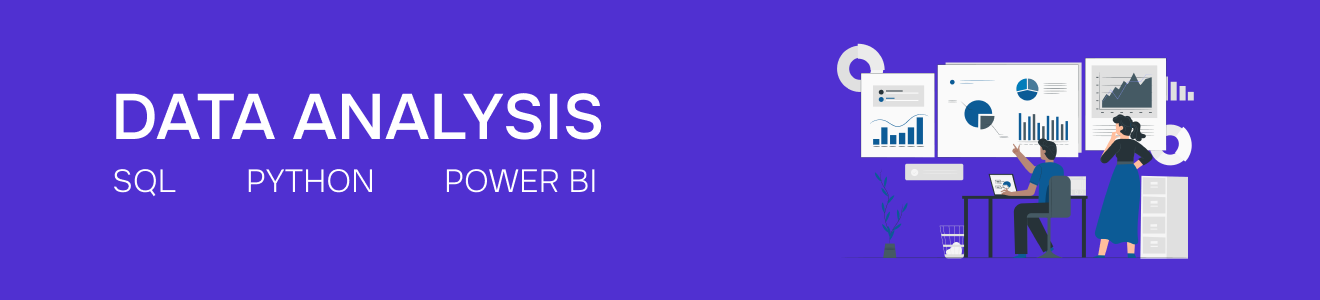

# <center> Study description

**Data description:**  
Bus tickets booking price for long-haul trips: price, number of persons, class of trip, destination, etc.  
Each row is a separate booking, may include several tickets for several people.

**Task description:**  
It is necessary to build linear model with interpretive coefficients to forecast booking price depending on varibles.

**Content:**
1. Importing data from SQL server
2. Data preparation
3. Adding features
4. Outliars correction and data overview
5. Testing models
6. Conclusion

In [291]:
import psycopg2
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.ensemble import RandomForestRegressor
import pickle

# <center>1. Importing data from sql server

In [3]:
# connecting to SQL server
conn = psycopg2.connect(host="...", port="...", database="postgres",
                       user="...", password="...")

In [4]:
cursor = conn.cursor()

In [5]:
# creating request
cursor.execute("select dt::date \
, date_part('year', dt::date) as year \
, date_part('month', dt::date) as month \
, date_part('day', dt::date) as day \
, case \
	when date_part('dow', dt::timestamp) = 0 \
	then 7 \
	else date_part('dow', dt::timestamp) \
	end as day_of_week \
, 1 as num_click \
, price_rub \
, price_usd \
, adults \
, children \
, infants \
, adults+children+infants as people \
, case \
	when destination_country = 'RU' \
	then 1 \
	else 0 \
end as dom \
, case \
	when trip_class = 'X' \
	then 1 \
	else 0 \
end as trip_class \
from s.clicks")

In [6]:
rows = cursor.fetchall()

In [205]:
# saving results of request as dataframe
df = pd.DataFrame(data = rows)

# <center> 2. Data preparation

In [206]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2022-06-16,2022.0,6.0,16.0,4.0,1,10728.00000,189.21000,3,0,0,3,1,1
1,2022-06-16,2022.0,6.0,16.0,4.0,1,9160.00000,161.55000,2,0,0,2,1,1
2,2022-06-16,2022.0,6.0,16.0,4.0,1,12599.00000,222.20000,2,0,0,2,1,1
3,2022-06-16,2022.0,6.0,16.0,4.0,1,8737.00000,154.09000,1,0,0,1,1,1
4,2022-06-16,2022.0,6.0,16.0,4.0,1,13730.00000,242.15000,1,0,0,1,1,1


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464404 entries, 0 to 5464403
Data columns (total 14 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       object 
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       int64  
 6   6       object 
 7   7       object 
 8   8       int64  
 9   9       int64  
 10  10      int64  
 11  11      int64  
 12  12      int64  
 13  13      int64  
dtypes: float64(4), int64(7), object(3)
memory usage: 583.7+ MB


In [208]:
# renaming of columns
df.rename({0:'date', 1:'year', 2:'month', 3:'day', 4:'week_day', 5:'click', 6:'price_rub',
           7:'price_usd', 8:'adult', 9:'child', 10:'infant', 11:'people', 12:'dom', 13:'econom'}, axis = 1, inplace = True)

In [209]:
# changing type of dateto proper one
df['date'] = pd.to_datetime(df['date'], dayfirst = True, infer_datetime_format=True)

In [211]:
# correcting data types of numbers
df = df.astype({'year': np.int64, 'month': np.int64, 'day': np.int64, 'week_day': np.int64, 
                'price_rub': np.float, 'price_usd': np.float})

In [212]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464404 entries, 0 to 5464403
Data columns (total 14 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   year       int64         
 2   month      int64         
 3   day        int64         
 4   week_day   int64         
 5   click      int64         
 6   price_rub  float64       
 7   price_usd  float64       
 8   adult      int64         
 9   child      int64         
 10  infant     int64         
 11  people     int64         
 12  dom        int64         
 13  econom     int64         
dtypes: datetime64[ns](1), float64(2), int64(11)
memory usage: 583.7 MB


In [213]:
df.head()

,date,year,month,day,week_day,click,price_rub,price_usd,adult,child,infant,people,dom,econom
0,2022-06-16,2022,6,16,4,1,10728.0,189.21,3,0,0,3,1,1
1,2022-06-16,2022,6,16,4,1,9160.0,161.55,2,0,0,2,1,1
2,2022-06-16,2022,6,16,4,1,12599.0,222.20,2,0,0,2,1,1
3,2022-06-16,2022,6,16,4,1,8737.0,154.09,1,0,0,1,1,1
4,2022-06-16,2022,6,16,4,1,13730.0,242.15,1,0,0,1,1,1


# <center> 3. Adding features

In [214]:
# adding information about forex rate
forex = pd.read_excel('C:/Users/abelova/Desktop/forex.xlsx')

In [215]:
forex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    219 non-null    object 
 1   forex   219 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.5+ KB


In [216]:
forex['date'] = pd.to_datetime(forex['date'], dayfirst = True, infer_datetime_format=True)

In [217]:
forex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    219 non-null    datetime64[ns]
 1   forex   219 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 KB


In [218]:
forex.head()

,date,forex
0,2022-01-01,85.93927
1,2022-02-01,87.76379
2,2022-03-01,114.71268
3,2022-04-01,84.58866
4,2022-05-01,67.62633


In [219]:
# adding information about holidays
holiday = pd.read_excel('C:/Users/abelova/Desktop/holiday.xlsx')

In [220]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     365 non-null    datetime64[ns]
 1   holiday  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [221]:
# merging all datasets to one
df = df.merge(forex)

In [222]:
df = df.merge(holiday)

In [223]:
# adding navigation period
df['summer']=df['date'].apply(lambda x: 1 if datetime.date(2022,3,27)<x<datetime.date(2022,10,29) else 0)

In [224]:
# adding season
df['season']=df['month'].apply(lambda x: 1 if 1<=x<=2 or x == 12 else (2 if 3<=x<=5 else (3 if 6<=x<=8 else 4)))

In [225]:
# adding two pairs of most common days of salary paying (5th and 20th and 10th and 25th)
df['pay_day']=df['day'].apply(lambda x: 1 if x == 5 or x == 10 or x == 25 or x == 20 else 0)

In [226]:
df.head()

,date,year,month,day,week_day,click,price_rub,price_usd,adult,child,infant,people,dom,econom,forex,holiday,summer,season,pay_day
0,2022-06-16,2022,6,16,4,1,10728.0,189.21,3,0,0,3,1,1,59.1204,0,1,3,0
1,2022-06-16,2022,6,16,4,1,9160.0,161.55,2,0,0,2,1,1,59.1204,0,1,3,0
2,2022-06-16,2022,6,16,4,1,12599.0,222.20,2,0,0,2,1,1,59.1204,0,1,3,0
3,2022-06-16,2022,6,16,4,1,8737.0,154.09,1,0,0,1,1,1,59.1204,0,1,3,0
4,2022-06-16,2022,6,16,4,1,13730.0,242.15,1,0,0,1,1,1,59.1204,0,1,3,0


In [292]:
# as data has more than 3 million rows, we will save it to pickle format
with open('tickets_full.pkl',  'wb') as f:
    pickle.dump(df, f)

# <center> 4. Outliars correction and data overview

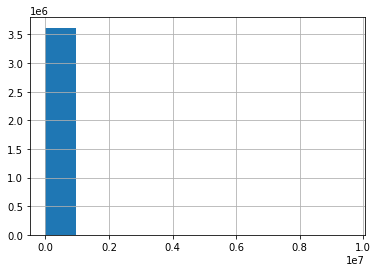

In [227]:
# overview of forecasted value
df["price_rub"].hist();

We see abnormal distribution of price with great outliers, but prices for bus tickets booking may be really high, if there are a lot of people in booking. So we cannot just delete high values of price, we should look at specific indicator.

In [228]:
df.describe()

,year,month,day,week_day,click,price_rub,price_usd,adult,child,infant,people,dom,econom,forex,holiday,summer,season,pay_day
count,3619292.0,3.619292e+06,3.619292e+06,3.619292e+06,3619292.0,3.618105e+06,3.618105e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06,3.619292e+06
mean,2022.0,6.435484e+00,1.594461e+01,3.897294e+00,1.0,2.233585e+04,3.453574e+02,1.269227e+00,1.078846e-01,2.275666e-02,1.399868e+00,6.960138e-01,9.976603e-01,6.975098e+01,2.930407e-03,7.776206e-01,2.846030e+00,1.227514e-01
std,0.0,2.806896e+00,8.756693e+00,1.402066e+00,0.0,4.371623e+04,6.886174e+02,5.744667e-01,3.904158e-01,1.525195e-01,7.991566e-01,4.599768e-01,4.831367e-02,1.722248e+01,5.405387e-02,4.158447e-01,9.950793e-01,3.281516e-01
min,2022.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,4.860000e+02,6.390000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.273790e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2022.0,4.000000e+00,8.000000e+00,3.000000e+00,1.0,5.129000e+03,7.634000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,5.939340e+01,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
50%,2022.0,7.000000e+00,1.600000e+01,4.000000e+00,1.0,1.027500e+04,1.560900e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.121710e+01,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00
75%,2022.0,9.000000e+00,2.300000e+01,5.000000e+00,1.0,2.281800e+04,3.503900e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,8.002490e+01,0.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00
max,2022.0,1.100000e+01,3.100000e+01,7.000000e+00,1.0,9.578225e+06,1.593052e+05,9.000000e+00,8.000000e+00,4.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,1.329581e+02,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00


In [229]:
df.shape

(3619292, 19)

In [230]:
# deleting rows with no information of price
df = df[~df['price_rub'].isnull()]

In [231]:
df.shape

(3618105, 19)

In [233]:
# adding checking feature - price of bus ticket per one person
df['PPP'] = df['price_rub']/df['people']

In [234]:
# finding great outliars
df['PPP'].sort_values(ascending = False)

1309349    2.627115e+06
2964199    1.955145e+06
2634123    1.854302e+06
68319      1.854087e+06
2634561    1.749730e+06
               ...     
2402696    4.440000e+02
2391730    4.440000e+02
105848     3.465000e+02
105849     3.465000e+02
115220     3.465000e+02
Name: PPP, Length: 3618105, dtype: float64

We find bookings with average bus ticket price for person, which is more than 2 million. Such prices are impossible, so we will analyze rows with PPP, which is less than 2 times standart deviation.

In [235]:
df = df[df['PPP']<2*df['PPP'].std()]

In [236]:
df['PPP'].std()

10381.61894600681

In [237]:
df.shape

(3383986, 20)

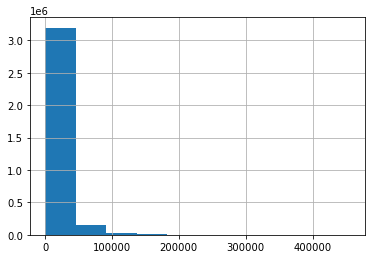

In [238]:
# checking booking price distribution again
df["price_rub"].hist();

Now destribution is more close to the possible and realistic one, most of booking have price less than 100 K.

In [243]:
df.head()

,date,year,month,day,week_day,click,price_rub,price_usd,adult,child,infant,people,dom,econom,forex,holiday,summer,season,pay_day,PPP
0,2022-06-16,2022,6,16,4,1,10728.0,189.21,3,0,0,3,1,1,59.1204,0,1,3,0,3576.0
1,2022-06-16,2022,6,16,4,1,9160.0,161.55,2,0,0,2,1,1,59.1204,0,1,3,0,4580.0
2,2022-06-16,2022,6,16,4,1,12599.0,222.20,2,0,0,2,1,1,59.1204,0,1,3,0,6299.5
3,2022-06-16,2022,6,16,4,1,8737.0,154.09,1,0,0,1,1,1,59.1204,0,1,3,0,8737.0
4,2022-06-16,2022,6,16,4,1,13730.0,242.15,1,0,0,1,1,1,59.1204,0,1,3,0,13730.0


In [244]:
# droping duplicating and unnecessary columns
df2 = df.drop(['year', 'day', 'date', 'click', 'PPP', 'price_usd'], axis =1)

In [267]:
df3 = pd.DataFrame(df2, columns=['month', 'week_day', 'adult', 'child', 'infant', 'people', 'dom',
                                'econom', 'forex', 'holiday', 'summer', 'season', 'pay_day', 'price_rub'])

In [269]:
df3.head()

,month,week_day,adult,child,infant,people,dom,econom,forex,holiday,summer,season,pay_day,price_rub
0,6,4,3,0,0,3,1,1,59.1204,0,1,3,0,10728.0
1,6,4,2,0,0,2,1,1,59.1204,0,1,3,0,9160.0
2,6,4,2,0,0,2,1,1,59.1204,0,1,3,0,12599.0
3,6,4,1,0,0,1,1,1,59.1204,0,1,3,0,8737.0
4,6,4,1,0,0,1,1,1,59.1204,0,1,3,0,13730.0


In [270]:
X, y = df3.drop("price_rub", axis=1), df3["price_rub"]

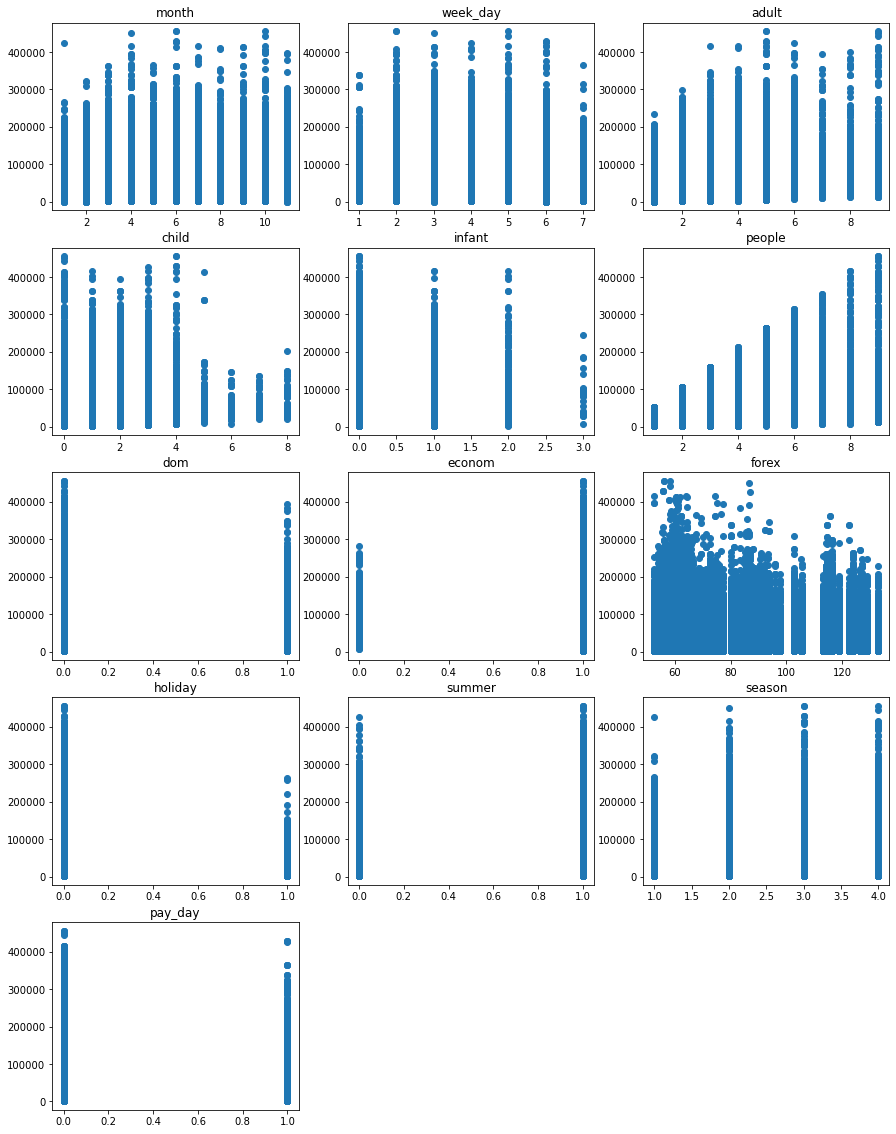

In [247]:
# buliding scatter plots of all features and forecasted value
plt.figure(figsize=(15, 20))
for i, col in enumerate(X.columns):
    plt.subplot(5, 3, i + 1)
    plt.scatter(X[col], y)
    plt.title(col, y = 1);

We see for season, week_day, month and forex not linear dependencies.  

Primary conclusions:
* With people number increase bus tickets total price is also increasing.
* Winter has lower booking prices than other seasons.  
* With higher forex rate booking prices are highter.
* With increase of children and infants number in booking, price is decreasing.  

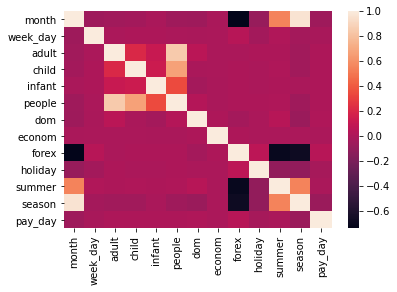

In [250]:
sns.heatmap(X.corr());

Features with people number strongly positively correlated, as well as season and summer variables, quite understandable.  
Forex rate and season have strong negative correlation, which is realistic.

# <center> 5. Testing models

In [251]:
# set linear models
linreg = LinearRegression()
lasso = Lasso(random_state=17)
ridge = Ridge(random_state=17)
lasso_cv = LassoCV(random_state=17)
ridge_cv = RidgeCV()

Let's divide the data into training and test samples, 70 by 30.  
Noting that the data is presented for one calendar year, so we will not divide it by index, as we have seasonlity in data.

In [252]:
еtrain_part_size = int(0.7*X.shape[0])

X_train = X.values[:еtrain_part_size, :]
X_valid = X.values[еtrain_part_size:, :]
y_train = y.values[:еtrain_part_size]
y_valid = y.values[еtrain_part_size:]

In [253]:
scaler = StandardScaler()
# learn and scale training set
X_train_scaled = scaler.fit_transform(X_train)
# scale test set
X_valid_scaled = scaler.transform(X_valid)

In [254]:
# train model on scaled sample
linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [255]:
# error on validation set
mean_squared_error(y_valid, linreg.predict(X_valid_scaled))

207345482.63794863

In [256]:
# root of above figure is interpreted error, measured in rubles
np.sqrt(mean_squared_error(y_valid, linreg.predict(X_valid_scaled)))

14399.495916105836

When spreading forecasted feature mostly from 10 to 100 K rubles, the error of 14,5 K rules looks reasonable.

In [271]:
pd.DataFrame(linreg.coef_, df3.columns[:-1], columns=['coef']).sort_values(by='coef', ascending = False)

,coef
adult,2.218960e+13
child,1.428741e+13
infant,5.773569e+12
season,1.245320e+03
summer,9.035253e+02
holiday,-4.443663e+00
week_day,-7.381212e+00
pay_day,-2.518911e+02
forex,-7.414365e+02
econom,-1.043002e+03


We got a list of coefficients sorted in descending order.

In [258]:
#We turn the previous steps from training to outputting coefficients into a function.
def train_validate_report(model, X_train_scaled, y_train, X_valid_scaled, y_valid, feature_names):
    model.fit(X_train_scaled, y_train)
    print("MSE=%f" % np.sqrt(mean_squared_error(y_valid, model.predict(X_valid_scaled))))
    print("Model coefficients:")
    print(pd.DataFrame(model.coef_, feature_names, columns=['coef']).sort_values(by='coef', ascending = False))

In [272]:
train_validate_report(lasso, X_train_scaled, y_train, X_valid_scaled, y_valid, feature_names=df3.columns[:-1])

MSE=14398.994141
Model coefficients:
                 Coef
adult     6561.693256
child     4264.359879
season    1208.529493
summer     908.023666
infant     766.412835
people       1.951405
holiday     -3.967929
week_day    -5.531854
pay_day   -251.686898
forex     -735.092342
econom   -1042.019352
month    -1472.630595
dom      -9003.234340


In [273]:
train_validate_report(lasso_cv, X_train_scaled, y_train, X_valid_scaled, y_valid, feature_names=df3.columns[:-1])

MSE=14327.658700
Model coefficients:
                 Coef
people    5718.340841
adult     2289.185484
child     1489.111091
summer    1057.991048
month       -0.000000
week_day     0.000000
holiday     -0.000000
season       0.000000
pay_day   -198.380731
infant    -224.649151
forex     -322.714319
econom    -962.421433
dom      -8911.959068


Lasso model overcame multicollinearity by assigning a factor of 0 to one of pair of correlating features.  
Minimum square error is lower after proper regularization coefficient selection: 14 399 -> 14 328 rub.  

In [274]:
train_validate_report(ridge, X_train_scaled, y_train, X_valid_scaled, y_valid, feature_names=df3.columns[:-1])

MSE=14399.820632
Model coefficients:
                 Coef
people    3881.287335
adult     3713.006941
child     2430.334760
season    1245.283954
summer     903.534211
infant      25.812094
holiday     -4.445182
week_day    -7.451717
pay_day   -251.891656
forex     -741.420168
econom   -1043.007905
month    -1511.678395
dom      -9003.980423


In [275]:
train_validate_report(ridge_cv, X_train_scaled, y_train, X_valid_scaled, y_valid, feature_names=df3.columns[:-1])

MSE=14399.821081
Model coefficients:
                 Coef
people    3881.279758
adult     3712.997149
child     2430.332052
season    1245.096391
summer     903.557968
infant      25.816754
holiday     -4.447876
week_day    -7.447495
pay_day   -251.895418
forex     -741.388196
econom   -1043.004126
month    -1511.479192
dom      -9003.946482


Best linear model after regularization is lasso with MSE 14 328 rub.

Just for interest let's check random forest model for bus booking price forecasting.

In [263]:
forest = RandomForestRegressor(n_estimators=50, random_state=17)

In [264]:
def train_validate_report(model, X_train_scaled, y_train, X_valid_scaled, y_valid, feature_names, forest = False):
    model.fit(X_train_scaled, y_train)
    print("MSE=%f" % np.sqrt(mean_squared_error(y_valid, model.predict(X_valid_scaled))))
    print("Model coefficients:")
    coef = model.feature_importances_ if forest else model.coef_
    coef_name = 'Importance' if forest else 'Coef'
    print(pd.DataFrame(coef, feature_names, columns=[coef_name]).sort_values(by=coef_name, ascending = False))

In [276]:
train_validate_report(forest, X_train, y_train, X_valid, y_valid, feature_names=df3.columns[:-1], forest=True)

MSE=12853.162788
Model coefficients:
          Importance
people      0.459409
dom         0.354196
forex       0.052366
month       0.043871
season      0.027097
adult       0.016971
week_day    0.013194
infant      0.012728
child       0.008906
econom      0.006851
pay_day     0.002785
summer      0.001530
holiday     0.000096


MSE is lower than any of linear model. So RF has higher accuracy, but less interpretive coefficients of variables.  
Most important features are - number of people, destination, forex rate, month and season.

In [286]:
# aggregating rows for future visualization
pivot = df.pivot_table(index=['date', 'week_day', 'forex','holiday','season','summer', 'pay_day'],
         values = ['click', 'price_rub','price_usd','adult','child','infant','people'], aggfunc = 'sum')

In [289]:
pivot.head()

,,,,,,,adult,child,click,infant,people,price_rub,price_usd
date,week_day,forex,holiday,season,summer,pay_day,,,,,,,
2022-01-11,2,85.1315,0,1,0,0,14795,1210,11728,209,16214,128852270.0,1718535.06
2022-01-12,3,84.8784,0,1,0,0,15398,1100,12033,238,16736,136802392.0,1825654.79
2022-01-13,4,84.6709,0,1,0,0,13841,1006,11050,184,15031,121821049.0,1635138.57
2022-01-14,5,85.4556,0,1,0,0,13590,924,10840,204,14718,118121131.0,1582279.01
2022-01-15,6,86.8894,0,1,0,0,11602,910,9080,174,12686,103745296.0,1359994.12


In [290]:
writer = pd.ExcelWriter('C:/Users/abelova/Desktop/tickets.xlsx')
pivot.to_excel(writer)
writer.save()

# <center> 6. Conclusion

1. Data has several multicollinear features.
2. Best MSE among linear models shows lasso model.
3. Lasso model overcomes multicollinearity.
4. Coefficient interpretation, using this model, is rather logical:
* with increasing of people, adults and children, number booking price increase,
* in summer season price increase,
* in salary days price decrease slightly - coefficient is negative, but rather unsignificant, 
* increasing of infats lead to price reduction,
* econom class of ticket reduces price,
* raise of forex rate also leads to booking price increase,
* domestic destinations are cheaper than international ones - most significant negative factor.
5. RF shows better results than lasso model.